<a href="https://colab.research.google.com/github/graccelinn/optimization_project1/blob/main/RM294_Optimization_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RM294 OPTIMIZATION - PROJECT 1**

*Members: Melissa Cai Shi, Grace Lin, Abhigyan Pandya, and Franco Salinas*

In [ ]:
# Collab requires to install Gurobi everytime
!pip install gurobipy

# load need libraries
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 64.1 MB/s eta 0:00:00


### **Part 1: Load and prepare data**

In [ ]:
# Load 2019 and 2020 data
stocks_2019_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Optimization I/stocks2019.csv', index_col=0, parse_dates=True)
stocks_2020_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Optimization I/stocks2020.csv', index_col=0, parse_dates=True, date_format='%m/%d/%y')

In [ ]:
# Rename the index column for formating
stocks_2019_df = stocks_2019_df.rename_axis('Date')
stocks_2020_df = stocks_2020_df.rename_axis('Date')

# Calculate returns; formula build in in python
returns_2019 = stocks_2019_df.pct_change().dropna()
returns_2020 = stocks_2020_df.pct_change().dropna()

# Remove NDX - this is the NASDAQ index, we want the individual stocks that make up the index/portfolio
returns_2019_noNDX = returns_2019.drop('NDX', axis=1)
returns_2020_noNDX = returns_2020.drop('NDX', axis=1)

## **Part 2: Base CVaR Optimization**

Finding portfolio that minimizes the daily average beta-CVaR using the 2019 data. Use beta = 0.95 and R = 0.02%. If you keep using the 2019 portfolio in 2020, what is the daily average B-CVaR in 2020? Is it a good idea to stick with the same portfolio across different years? Briefly justify using the differences between in-sample and out-of-sample daily average CVaR, and comment on potential non-stationarity.

In [ ]:
# Set Inputs values
beta = 0.95
R = 0.0002

In [ ]:
# ----------  Part 2a: Base CVaR Optimization ----------

# Get number of stocks variable; NASDAQ consist of 100 stocks
num_stocks_2019 = returns_2019_noNDX.shape[1]

# Get number of days variable q; 250 trading days
q_num_days_2019 = len(returns_2019_noNDX)


# ----------  β-CVaR Minimization (β=0.95, R=0.02%) ----------

# Create the Gurobi model
CVaR_model_2019 = gp.Model("CVaR_Optimization_2019")

# Add/Define decision variables
x_2019 = CVaR_model_2019.addMVar(num_stocks_2019, lb=0.0, name="weights") # here set non-negative contraint
alpha_2019 = CVaR_model_2019.addMVar(1, name="VaR")
u_2019 = CVaR_model_2019.addMVar(q_num_days_2019, lb=0.0, name="excess_loss") # here set non-negative contraint

# Set the objective function: Minimize CVaR
CVaR_model_2019.setObjective(alpha_2019 + (1 / ((1 - beta) * q_num_days_2019)) * u_2019.sum(), gp.GRB.MINIMIZE)

# Add constraints (@ is for matrix operation)
CVaR_model_2019.addConstr(x_2019.sum() == 1, name="weights_sum_one_constraint")
CVaR_model_2019.addConstr(returns_2019_noNDX.mean().values @ x_2019 >= R, name="min_return_constraint")
CVaR_model_2019.addConstr(-returns_2019_noNDX.values @ x_2019 - alpha_2019 <= u_2019, name="excess_loss_constraint")

# Solve the model
CVaR_model_2019.Params.OutputFlag = 0 # Suppress Gurobi output
CVaR_model_2019.optimize()

Restricted license - for non-production use only - expires 2026-11-23


--- In-sample Optimization Results (2019 Data) ---
In-sample Optimal VaR (2019): 0.008500
In-sample Optimal CVaR (2019): 0.011090

Portfolio Composition (Non-Zero Weights):
  XEL: 30.39%
  CHTR: 26.50%
  AMGN: 8.08%
  CTXS: 6.56%
  CHKP: 6.27%
  EXC: 5.22%
  KHC: 4.05%
  CSX: 3.43%
  COST: 3.04%
  EBAY: 2.35%
  JD: 1.98%
  CTSH: 1.96%
  LULU: 0.18%

--- Out-of-Sample Performance (2020 Data) ---
Out-of-Sample VaR (2020): 0.025250
Out-of-Sample CVaR (2020): 0.045830

--- NDX Index Performance ---

--- 2019 ---
NDX VaR (2019): 0.015955
NDX CVaR (2019): 0.024414

--- 2020 ---
NDX VaR (2020): 0.038977
NDX CVaR (2020): 0.055892


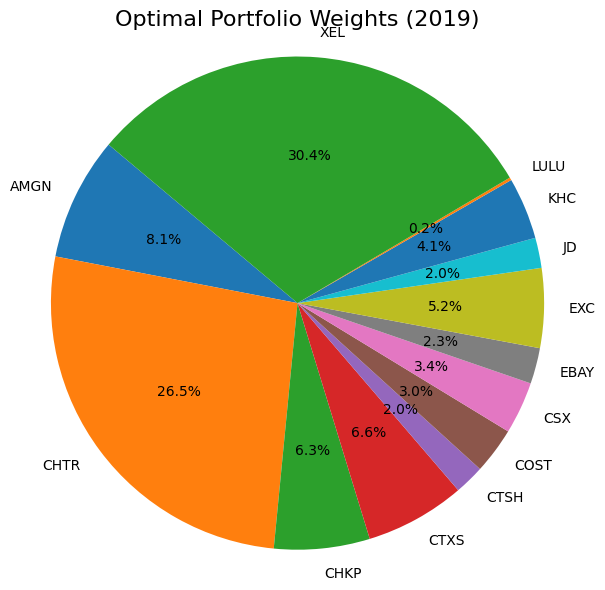

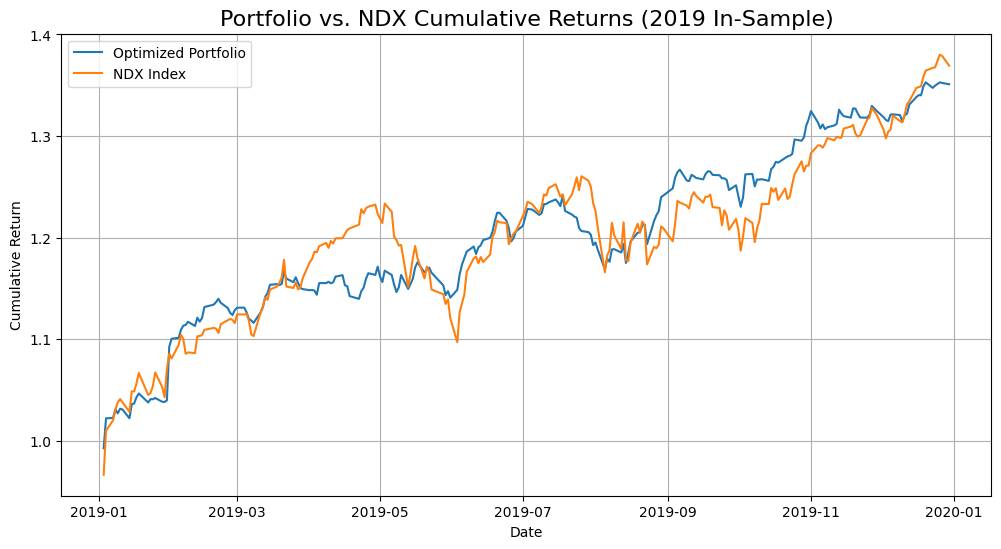

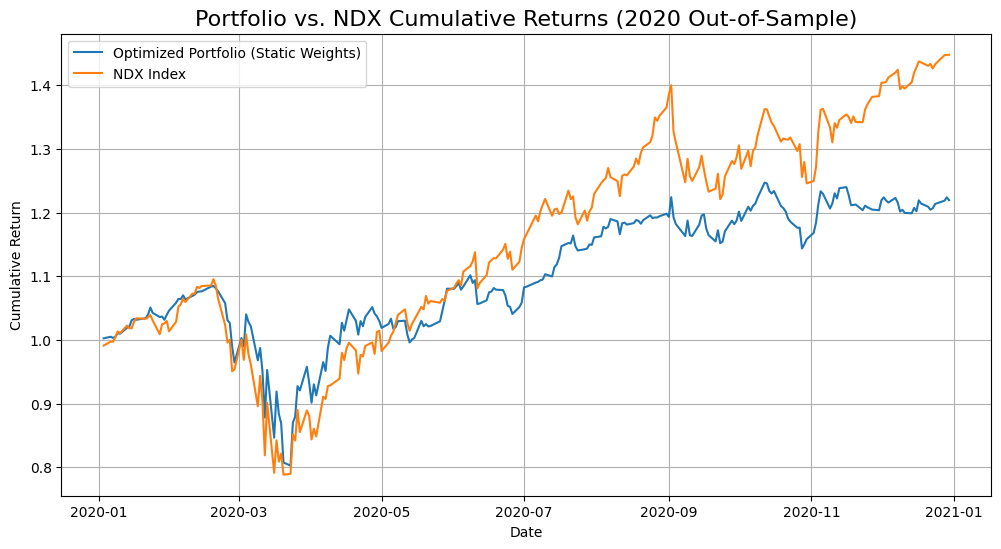

In [ ]:
# --- Display Optimization Results ---
if CVaR_model_2019.status == gp.GRB.OPTIMAL:
    print("--- In-sample Optimization Results (2019 Data) ---")

    # Extract and print VaR and CVaR
    optimal_VaR_2019 = alpha_2019.X[0]
    optimal_CVaR_2019 = CVaR_model_2019.ObjVal
    print(f"In-sample Optimal VaR (2019): {optimal_VaR_2019:.6f}")
    print(f"In-sample Optimal CVaR (2019): {optimal_CVaR_2019:.6f}\n")

    # Extract, filter, and print non-zero weights
    weights_2019 = pd.Series(x_2019.X, index=returns_2019_noNDX.columns)
    non_zero_weights_2019 = weights_2019[weights_2019 > 1e-6] # Use a small threshold to avoid floating point noise

    print("Portfolio Composition (Non-Zero Weights):")
    # Sort weights in descending order for better presentation
    for stock, weight in non_zero_weights_2019.sort_values(ascending=False).items():
        print(f"  {stock}: {weight:.2%}")


    # ---------- Part 2b: Re-evaluating the portfolio with 2020 data (Out-of-Sample Test) ----------
    # Use the optimal weights from 2019 to test on 2020 data
    # Calculate portfolio returns for 2020 using 2019 weights
    portfolio_returns_2020 = returns_2020_noNDX @ weights_2019
    # Calculate portfolio losses for 2020
    portfolio_losses_2020 = -portfolio_returns_2020

    # Calculate out-of-sample VaR and CVaR
    out_of_sample_VaR_2020 = portfolio_losses_2020.quantile(beta)
    out_of_sample_CVaR_2020 = portfolio_losses_2020[portfolio_losses_2020 >= out_of_sample_VaR_2020].mean()

    print("\n--- Out-of-Sample Performance (2020 Data) ---")
    print(f"Out-of-Sample VaR (2020): {out_of_sample_VaR_2020:.6f}")
    print(f"Out-of-Sample CVaR (2020): {out_of_sample_CVaR_2020:.6f}")


    # ---------- Part 2c: Calculate CVaR for the NDX Index ----------
    print("\n--- NDX Index Performance ---")

    # --- 2019 NDX Performance ---
    # Isolate NDX returns for 2019 and get losses
    ndx_losses_2019 = -returns_2019['NDX']
    # Calculate NDX VaR
    ndx_VaR_2019 = ndx_losses_2019.quantile(beta)
    # Calculate NDX CVaR
    ndx_CVaR_2019 = ndx_losses_2019[ndx_losses_2019 >= ndx_VaR_2019].mean()
    print("\n--- 2019 ---")
    print(f"NDX VaR (2019): {ndx_VaR_2019:.6f}")
    print(f"NDX CVaR (2019): {ndx_CVaR_2019:.6f}")

    # --- 2020 NDX Performance ---
    ndx_losses_2020 = -returns_2020['NDX']
    ndx_VaR_2020 = ndx_losses_2020.quantile(beta)
    ndx_CVaR_2020 = ndx_losses_2020[ndx_losses_2020 >= ndx_VaR_2020].mean()
    print("\n--- 2020 ---")
    print(f"NDX VaR (2020): {ndx_VaR_2020:.6f}")
    print(f"NDX CVaR (2020): {ndx_CVaR_2020:.6f}")


    # ----------  Part 2d: Visualizations ----------

    # --- Pie Chart of Portfolio Weights ---
    plt.figure(figsize=(7, 7))
    plt.pie(non_zero_weights_2019, labels=non_zero_weights_2019.index, autopct='%1.1f%%', startangle=140)
    plt.title('Optimal Portfolio Weights (2019)', fontsize=16)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    # --- Cumulative Return Plot (2019 In-Sample) ---
    portfolio_returns_2019 = returns_2019_noNDX @ weights_2019
    cumulative_portfolio_returns_2019 = (1 + portfolio_returns_2019).cumprod()
    cumulative_ndx_returns_2019 = (1 + returns_2019['NDX']).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_portfolio_returns_2019.index, cumulative_portfolio_returns_2019, label='Optimized Portfolio')
    plt.plot(cumulative_ndx_returns_2019.index, cumulative_ndx_returns_2019, label='NDX Index')
    plt.title('Portfolio vs. NDX Cumulative Returns (2019 In-Sample)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Cumulative Return Plot (2020 Out-of-Sample) ---
    cumulative_portfolio_returns_2020 = (1 + portfolio_returns_2020).cumprod()
    cumulative_ndx_returns_2020 = (1 + returns_2020['NDX']).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_portfolio_returns_2020.index, cumulative_portfolio_returns_2020, label='Optimized Portfolio (Static Weights)')
    plt.plot(cumulative_ndx_returns_2020.index, cumulative_ndx_returns_2020, label='NDX Index')
    plt.title('Portfolio vs. NDX Cumulative Returns (2020 Out-of-Sample)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Optimization was not successful.")

## **Part 3: Impact of Beta (Risk Tolerance) on Portfolio Construction**

Rerun your portfolio model using the 2019 data with beta=0.90 and beta=0.99. How do different beta values
affect the portfolio allocation?

In [ ]:
# Define the beta values to test
beta_values = [0.90, 0.95, 0.99]


--- Impact of Beta on Portfolio Composition (2019 Data) ---

--- Beta = 0.9 ---
Optimal CVaR: 0.008900
Portfolio Composition (Non-Zero Weights):
  CHTR: 24.06%
  XEL: 21.30%
  MDLZ: 13.66%
  EXC: 6.43%
  WBA: 5.29%
  EBAY: 4.87%
  AMGN: 4.80%
  CTXS: 4.73%
  ORLY: 4.20%
  PEP: 3.16%
  DLTR: 3.07%
  CHKP: 1.83%
  KHC: 1.47%
  DXCM: 0.48%
  QCOM: 0.37%
  CPRT: 0.29%

--- Beta = 0.95 ---
Optimal CVaR: 0.011090
Portfolio Composition (Non-Zero Weights):
  XEL: 30.39%
  CHTR: 26.50%
  AMGN: 8.08%
  CTXS: 6.56%
  CHKP: 6.27%
  EXC: 5.22%
  KHC: 4.05%
  CSX: 3.43%
  COST: 3.04%
  EBAY: 2.35%
  JD: 1.98%
  CTSH: 1.96%
  LULU: 0.18%

--- Beta = 0.99 ---
Optimal CVaR: 0.012451
Portfolio Composition (Non-Zero Weights):
  XEL: 44.70%
  CHTR: 24.81%
  CTXS: 8.91%
  KHC: 6.73%
  NTES: 5.10%
  SPLK: 4.66%
  AMGN: 3.63%
  DXCM: 0.82%
  SIRI: 0.65%


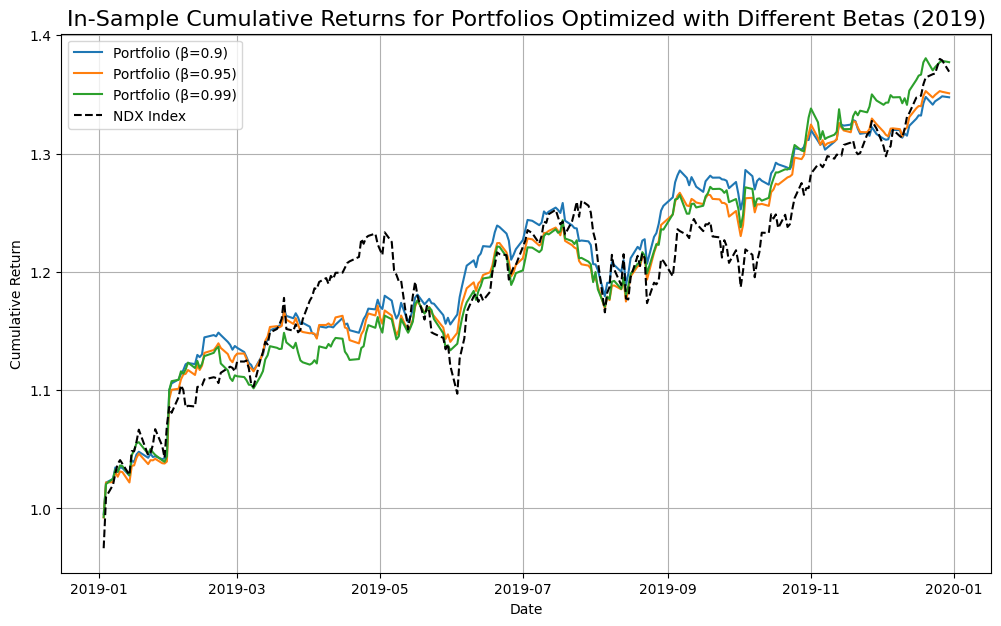

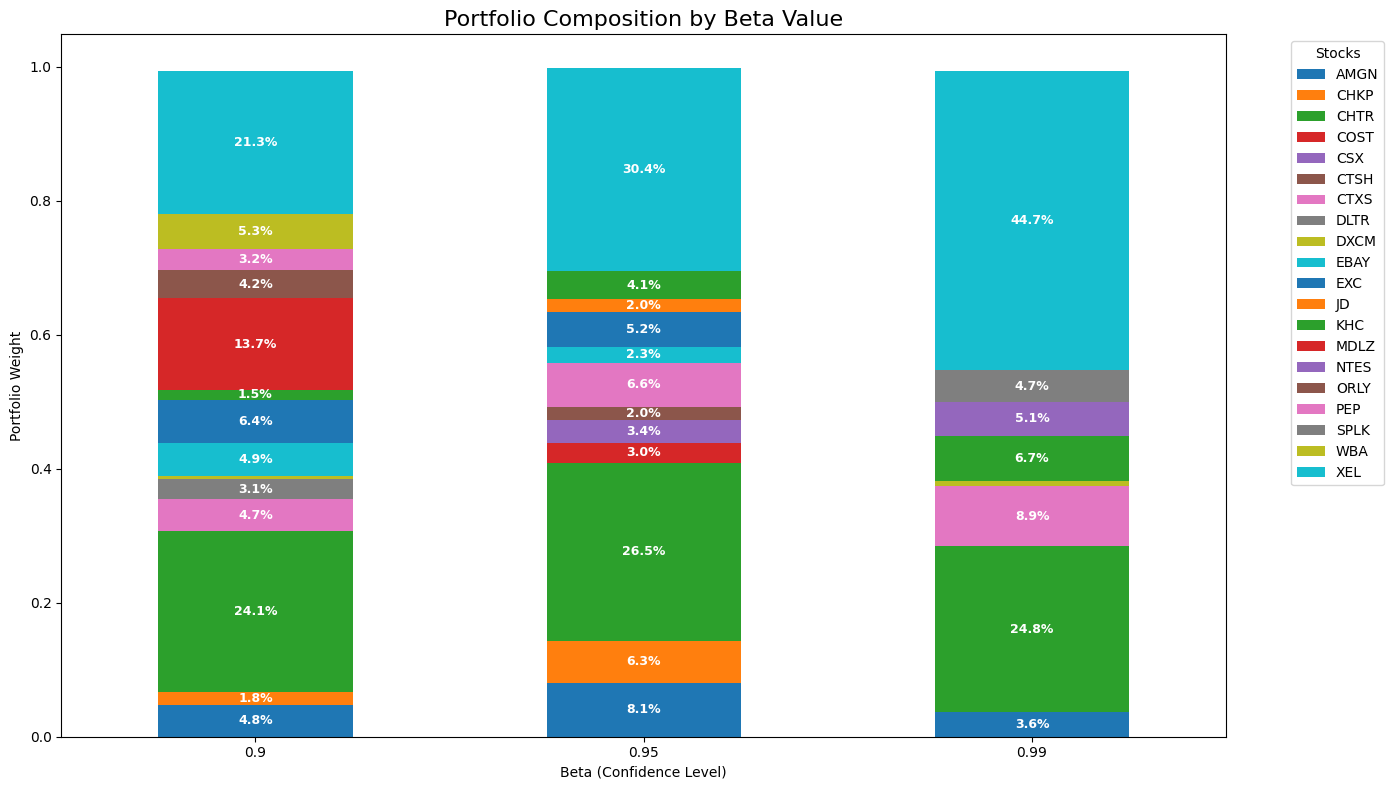

In [ ]:
# Define veriables needed
cvar_results = []
portfolio_compositions = {}
portfolio_returns_by_beta = {} # To store daily returns for each beta portfolio

# Loop through each beta value
for beta_val in beta_values:
    # Create the Gurobi model for each beta
    beta_model = gp.Model(f"CVaR_Optimization_Beta_{beta_val}")

    # Add/Define decision variables
    x = beta_model.addMVar(num_stocks_2019, lb=0.0, name="weights")
    alpha = beta_model.addMVar(1, name="VaR")
    u = beta_model.addMVar(q_num_days_2019, lb=0.0, name="excess_loss")

    # Set the objective function: Minimize CVaR
    beta_model.setObjective(alpha + (1 / ((1 - beta_val) * q_num_days_2019)) * u.sum(), gp.GRB.MINIMIZE)

    # Add constraints
    beta_model.addConstr(x.sum() == 1, name="weights_sum_one_constraint")
    beta_model.addConstr(returns_2019_noNDX.mean().values @ x >= R, name="min_return_constraint")
    beta_model.addConstr(-returns_2019_noNDX.values @ x - alpha <= u, name="excess_loss_constraint")

    # Suppress Gurobi output and solve the model
    beta_model.Params.OutputFlag = 0
    beta_model.optimize()

    # Store results if optimization is successful
    if beta_model.status == gp.GRB.OPTIMAL:
        cvar_results.append(beta_model.ObjVal)
        weights = pd.Series(x.X, index=returns_2019_noNDX.columns)
        non_zero_weights = weights[weights > 1e-6]
        portfolio_compositions[beta_val] = non_zero_weights

        # Calculate and store daily returns for this portfolio
        daily_returns = returns_2019_noNDX @ weights
        portfolio_returns_by_beta[beta_val] = daily_returns
    else:
        print(f"Optimization for Beta = {beta_val} was not successful.")
        cvar_results.append(None)
        portfolio_compositions[beta_val] = pd.Series()

# --- Display Beta Sensitivity Results ---
print("\n--- Impact of Beta on Portfolio Composition (2019 Data) ---")
for beta_val, composition in portfolio_compositions.items():
    print(f"\n--- Beta = {beta_val} ---")
    if cvar_results[beta_values.index(beta_val)] is not None:
        print(f"Optimal CVaR: {cvar_results[beta_values.index(beta_val)]:.6f}")
        print("Portfolio Composition (Non-Zero Weights):")
        for stock, weight in composition.sort_values(ascending=False).items():
            print(f"  {stock}: {weight:.2%}")
    else:
        print("Could not find an optimal solution.")


# --- Plot Cumulative Returns for each Beta ---
if portfolio_returns_by_beta:
    plt.figure(figsize=(12, 7))

    # Plot each optimized portfolio's cumulative return
    for beta_val, daily_returns in portfolio_returns_by_beta.items():
        cumulative_returns = (1 + daily_returns).cumprod()
        plt.plot(cumulative_returns.index, cumulative_returns, label=f'Portfolio (β={beta_val})')

    # Also plot the NDX for comparison
    cumulative_ndx_returns_2019 = (1 + returns_2019['NDX']).cumprod()
    plt.plot(cumulative_ndx_returns_2019.index, cumulative_ndx_returns_2019, label='NDX Index', color='black', linestyle='--')

    plt.title('In-Sample Cumulative Returns for Portfolios Optimized with Different Betas (2019)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Stacked Bar Chart for Portfolio Composition ---
# Create a DataFrame from the collected weights
weights_df = pd.DataFrame(portfolio_compositions).fillna(0).T

# Only plot stocks that have a significant weight in at least one portfolio to keep the chart clean
significant_stocks = weights_df.columns[weights_df.sum() > 0.01]
weights_df_filtered = weights_df[significant_stocks]

# Plotting
ax = weights_df_filtered.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Portfolio Composition by Beta Value', fontsize=16)
plt.xlabel('Beta (Confidence Level)')
plt.ylabel('Portfolio Weight')
plt.xticks(rotation=0)
plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add the percentages on the bars
for c in ax.containers:
    # Create labels, displaying only for segments > 1%
    labels = [f'{w:.1%}' if (w := v.get_height()) > 0.01 else '' for v in c]

    # Add labels to the bars
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## **Part 4: Conservative risk management approach**

Your team proposes a conservative risk management approach: instead of minimizing the average risk
over time, focus on minimizing the maximum monthly β-CVaR across the year. By controlling the single
worst month’s tail loss, the portfolio will be better protected against extreme adverse conditions. Run
your model again using the 2019 data with this objective. Compare with Part 2.

## **Part 5: Dynamic Monthly Re-optimization**

The mathematical model for each month's optimization is identical to the baseline model from Part 2. The difference is procedural: you are running that same optimization 12 times, each time with a different, rolling data window. For each month t in 2020 (from Jan to Dec):

* Select Data: Create a dataset of daily returns from the previous 12 months (e.g., for Jan 2020, use data from Jan 2019 - Dec 2019).
* Solve: Solve the baseline CVaR optimization problem using this 12-month data slice to find the optimal portfolio for that month, x(t).
* Store & Repeat: Store the resulting portfolio weights x
(t) and move to the next month.

In [ ]:
# Select year you are implementing the moving window
analysis_year = 2020

In [ ]:
def solve_cvar_weights(train_returns_df, beta_val=beta, R_floor=R):
    """Solve the standard CVaR LP on a training DataFrame."""
    Yt = train_returns_df.to_numpy()
    qt, nt = Yt.shape
    mut = train_returns_df.mean().to_numpy()

    m = gp.Model("cvar_monthly_train")
    m.Params.OutputFlag = 0

    x = m.addMVar(nt, lb=0.0, name="weights")
    a = m.addMVar(1, lb=-gp.GRB.INFINITY, name="VaR")
    u = m.addMVar(qt, lb=0.0, name="excess_loss")

    m.addConstr(x.sum() == 1)
    m.addConstr(mut @ x >= R_floor)
    m.addConstr(-Yt @ x - a <= u)

    coef = 1 / ((1 - beta_val) * qt)
    m.setObjective(a + coef * u.sum(), gp.GRB.MINIMIZE)
    m.optimize()

    if m.status == gp.GRB.OPTIMAL:
        return pd.Series([var.X for var in x.tolist()], index=train_returns_df.columns)
    else:
        return pd.Series(dtype='float64')

# --- Helper Function to Calculate Empirical VaR and CVaR ---
def var_cvar(wts, returns_df, beta_val=beta):
    """Calculates empirical VaR and CVaR for a given set of weights and returns."""
    if wts.empty or returns_df.empty:
        return np.nan, np.nan
    portfolio_returns = returns_df[wts.index].to_numpy() @ wts.to_numpy()
    losses = -portfolio_returns
    v = np.quantile(losses, beta_val)
    c = losses[losses >= v - 1e-12].mean()
    return float(v), float(c)


--- Monthly Realized Out-of-Sample CVaR (2020) ---
             cvar
month            
2020-01  0.008140
2020-02  0.035750
2020-03  0.089341
2020-04  0.037716
2020-05  0.029995
2020-06  0.018034
2020-07  0.023987
2020-08  0.015343
2020-09  0.033631
2020-10  0.023231
2020-11  0.021530
2020-12  0.015939

--- Summary of Monthly CVaRs ---
Mean  : 0.029387
Std   : 0.020911
Min   : 0.008140  (in month 2020-01)
Max   : 0.089341  (in month 2020-03)


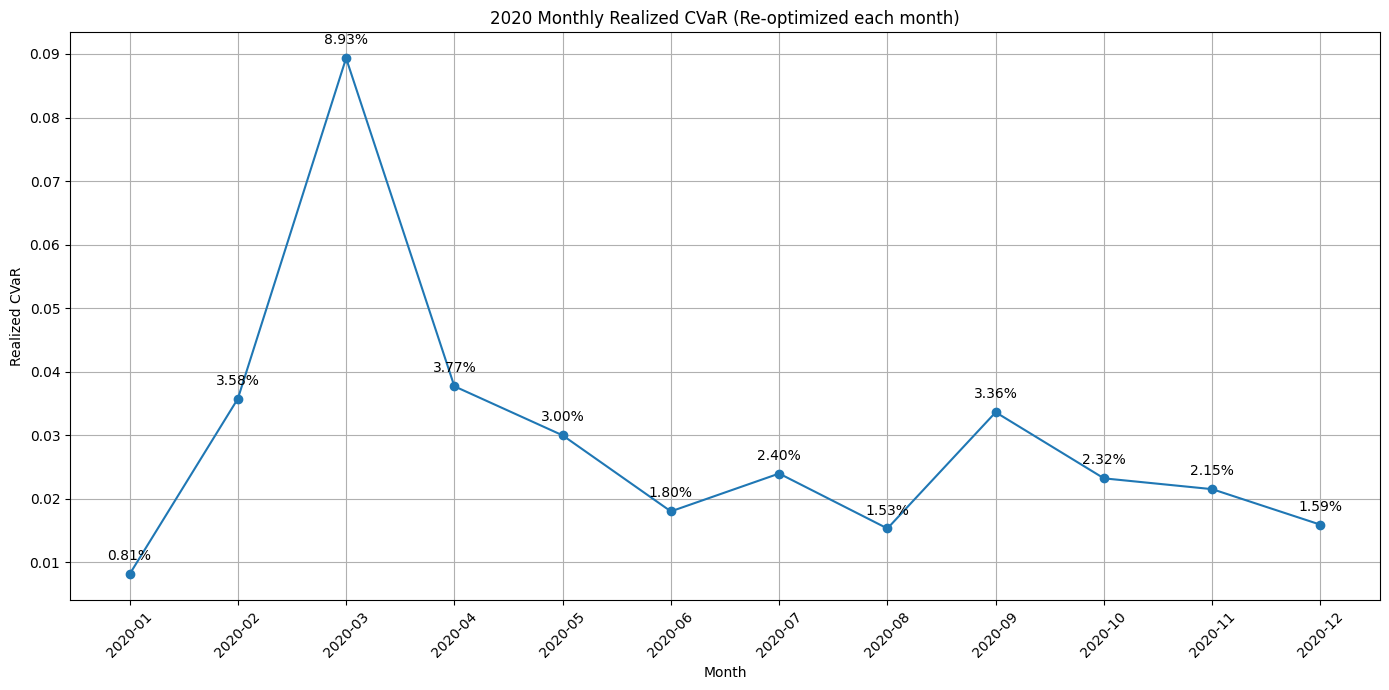

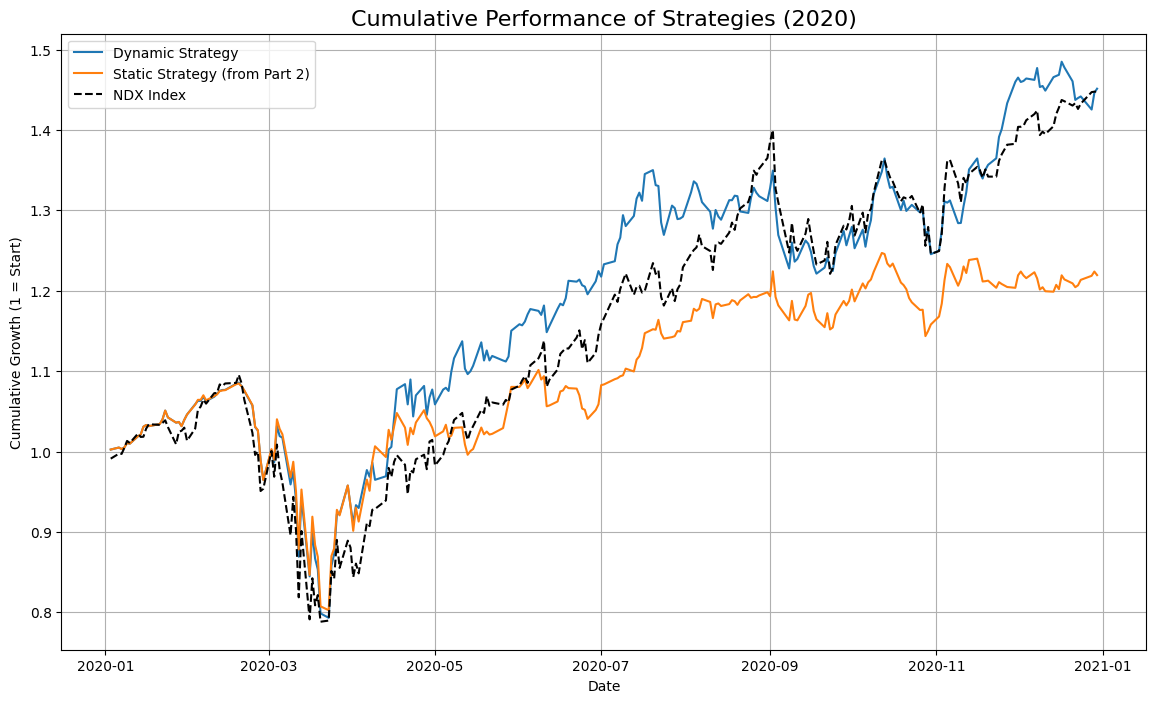

In [ ]:
# --- Main Dynamic Analysis Loop ---
# Combine all returns for the rolling window
all_returns = pd.concat([returns_2019_noNDX, returns_2020_noNDX]).sort_index()

monthly_results = []
dynamic_portfolio_weights = {} # Renamed for consistency with Part 6
dynamic_daily_returns_list = [] # To store daily returns for the cumulative plot
months_2020 = returns_2020.index.to_period("M").unique().tolist()

for mth in months_2020:
    # Define the rolling window
    end_of_prev_month = (mth.start_time - pd.offsets.Day(1))
    start_12m = end_of_prev_month - DateOffset(years=1) + pd.offsets.Day(1)
    train_mask = (all_returns.index >= start_12m) & (all_returns.index <= end_of_prev_month)
    train_df = all_returns.loc[train_mask, assets]

    # Solve for this month's portfolio
    w_m = solve_cvar_weights(train_df)

    # Store weights for Part 6 analysis
    month_key = end_of_prev_month.strftime('%Y-%m')
    dynamic_portfolio_weights[month_key] = w_m

    # Evaluate on the actual returns for month mth
    test_mask = (returns_2020_noNDX.index.to_period("M") == mth)
    test_df = returns_2020_noNDX.loc[test_mask, assets]
    _, cvar_m = var_cvar(w_m, test_df)

    monthly_results.append({
        "month": str(mth),
        "cvar": float(cvar_m)
    })

    # Calculate and store daily returns for the cumulative performance plot
    if not w_m.empty and not test_df.empty:
        daily_p_returns = test_df[w_m.index] @ w_m
        dynamic_daily_returns_list.append(daily_p_returns)


# --- Display Results ---
monthly_cvar_df = pd.DataFrame(monthly_results).set_index("month")
print("\n--- Monthly Realized Out-of-Sample CVaR (2020) ---")
print(monthly_cvar_df)

print("\n--- Summary of Monthly CVaRs ---")
print(f"Mean  : {monthly_cvar_df['cvar'].mean():.6f}")
print(f"Std   : {monthly_cvar_df['cvar'].std(ddof=1):.6f}")
print(f"Min   : {monthly_cvar_df['cvar'].min():.6f}  (in month {monthly_cvar_df['cvar'].idxmin()})")
print(f"Max   : {monthly_cvar_df['cvar'].max():.6f}  (in month {monthly_cvar_df['cvar'].idxmax()})")

# --- Monthly CVaR Plot with Annotations (Corrected) ---
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(monthly_cvar_df.index, monthly_cvar_df['cvar'], marker='o')

# Add percentage labels to each point
for i, (idx, row) in enumerate(monthly_cvar_df.iterrows()):
    ax.annotate(f'{row["cvar"]:.2%}',
                (i, row["cvar"]),  # Use the numerical index 'i' for the x-coordinate
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Set plot details
ax.set_title("2020 Monthly Realized CVaR (Re-optimized each month)")
ax.set_ylabel("Realized CVaR")
ax.set_xlabel("Month")
ax.grid(True)
plt.xticks(rotation=45) # Rotate labels for better readability
plt.tight_layout()
plt.show()

# --- Cumulative Returns Plot for Dynamic Strategy ---
if dynamic_daily_returns_list:
    # Combine all the monthly daily returns into a single Series for the year
    full_year_dynamic_returns = pd.concat(dynamic_daily_returns_list)

    # Calculate cumulative returns for all three strategies
    cumulative_dynamic = (1 + full_year_dynamic_returns).cumprod()
    cumulative_static = (1 + portfolio_returns_2020).cumprod() # Calculated in Part 2
    cumulative_ndx = (1 + returns_2020['NDX']).cumprod()


    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(cumulative_dynamic.index, cumulative_dynamic, label='Dynamic Strategy')
    plt.plot(cumulative_static.index, cumulative_static, label='Static Strategy (from Part 2)')
    plt.plot(cumulative_ndx.index, cumulative_ndx, label='NDX Index', color='black', linestyle='--')

    plt.title(f'Cumulative Performance of Strategies ({analysis_year})', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth (1 = Start)')
    plt.legend()
    plt.grid(True)
    plt.show()

## **Part 6: Portfolio Stability Analysis**


Analysis of weight changes greater than 5%:
         num_violations
month                  
2020-01               0
2020-02               5
2020-03               9
2020-04               5
2020-05               4
2020-06               2
2020-07               4
2020-08               8
2020-09               5
2020-10               1
2020-11               0

Total asset-level violations across 2020: 43

--- Top 10 Largest Month-to-Month Weight Changes ---
asset   month  abs_change
 CTXS 2020-03    0.451674
  XEL 2020-03    0.332126
 CHTR 2020-03    0.296739
 COST 2020-08    0.289998
 CTXS 2020-04    0.204316
 COST 2020-09    0.195871
 CTXS 2020-05    0.195848
 EBAY 2020-08    0.167736
 EBAY 2020-04    0.158282
 GILD 2020-03    0.154766


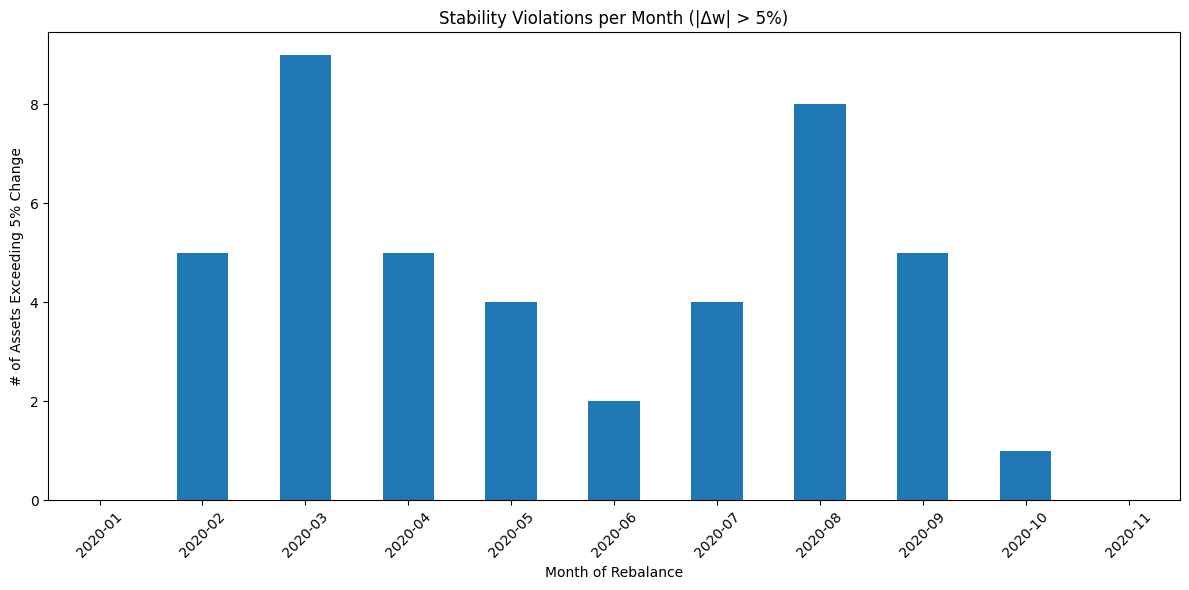

In [ ]:
if 'dynamic_portfolio_weights' in locals() and dynamic_portfolio_weights:

    # Order the months chronologically to ensure correct difference calculation
    ordered_months = sorted(dynamic_portfolio_weights.keys())

    # Create a DataFrame from the weights dictionary. Rows=assets, cols=months
    W = pd.DataFrame({m: dynamic_portfolio_weights[m] for m in ordered_months}).fillna(0)

    # Calculate the month-to-month absolute change in weights
    W_diff = W.diff(axis=1).abs()

    # Define the threshold for what constitutes a "large" change (e.g., 5 percentage points)
    STABILITY_THRESHOLD = 0.05

    # Identify violations, excluding the first month which has no prior data to compare
    violations = (W_diff.iloc[:, 1:] > STABILITY_THRESHOLD)

    # Count the number of violations for each month
    violations_count_by_month = violations.sum(axis=0)

    print(f"\nAnalysis of weight changes greater than {STABILITY_THRESHOLD:.0%}:")

    stab_df = pd.DataFrame({
        "month": violations.columns,
        "num_violations": violations_count_by_month.values
    }).set_index("month")

    print(stab_df)

    total_violations = int(violations_count_by_month.sum())
    print(f"\nTotal asset-level violations across {analysis_year}: {total_violations}")

    # Show top 10 largest month-to-month moves for diagnostics
    largest_moves = (
        W_diff.stack()
            .reset_index()
            .rename(columns={"level_0": "asset", "level_1": "month", 0: "abs_change"})
            .sort_values("abs_change", ascending=False)
    )

    print("\n--- Top 10 Largest Month-to-Month Weight Changes ---")
    print(largest_moves.head(10).to_string(index=False))

    # Optional: Plot violations per month
    violations_count_by_month.plot(
        kind="bar",
        figsize=(12, 6),
        title=f"Stability Violations per Month (|Δw| > {STABILITY_THRESHOLD:.0%})"
    )
    plt.ylabel(f"# of Assets Exceeding {STABILITY_THRESHOLD:.0%} Change")
    plt.xlabel("Month of Rebalance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Could not perform stability analysis because dynamic portfolio weights were not calculated in Part 5.")


In [ ]:
# END